# Transformers

In this notebook, we will be implementing a simple GPT-style decoder-only Transformer. The implementation is inspired by [nanoGPT](https://github.com/karpathy/nanoGPT/tree/master) for the task of next-token prediction. We will use the tiny Shakespeare dataset, which contains everything William Shakespeare has ever written. The implementation is annotated with useful comments and considerations.  

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np

## Shakespeare dataset

Download the tiny Shakespeare dataset [here](https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt).

In [3]:
from torch.utils.data import DataLoader, Dataset

class VocabDataset(Dataset):
    def __init__(self, file_patch: str, seq_len: int):
        f = open(file_patch, 'r')
        corpus = f.read()
        f.close()
        self.seq_len = seq_len
        self.vocab = sorted(list(set(corpus)))
        self.vocab_size = len(self.vocab)
        self.stoi = dict(zip(self.vocab, range(self.vocab_size)))

        self.encoder = lambda c: [self.stoi[ci] for ci in c]
        self.decoder = lambda x: [self.vocab[xi] for xi in x]
        self.data = torch.tensor(self.encoder(corpus))

    def __getitem__(self, index):
        x = self.data[index: index + self.seq_len]
        y = self.data[index+1: index + self.seq_len+1]
        return x, y

    def __len__(self):
        return len(self.data) - self.seq_len

In [4]:
dataset = VocabDataset("../datasets/shakespeare.txt", seq_len=8)

print(f"length of dataset in characters: {len(dataset.data):,}")

# get all the unique characters that occur in this text
print("all the unique characters:", ''.join(dataset.vocab))
print(f"vocab size: {dataset.vocab_size:,}")

length of dataset in characters: 1,115,389
all the unique characters: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
vocab size: 65


In [5]:
loader = DataLoader(dataset, batch_size=4, shuffle=False)

for i, (x, y) in enumerate(loader):

    print(f"batch x shape: {x.shape}\nbatch y shape: {y.shape}")
    for j, (xi, yi) in enumerate(zip(x, y)):
        print(f"batch sample {j}: x=[{''.join(dataset.decoder(xi))}]\t y=[{''.join(dataset.decoder(yi))}]")

    if i == 0: break

batch x shape: torch.Size([4, 8])
batch y shape: torch.Size([4, 8])
batch sample 0: x=[First Ci]	 y=[irst Cit]
batch sample 1: x=[irst Cit]	 y=[rst Citi]
batch sample 2: x=[rst Citi]	 y=[st Citiz]
batch sample 3: x=[st Citiz]	 y=[t Citize]


## Transformer modules

### Embedding and Positional Encoding

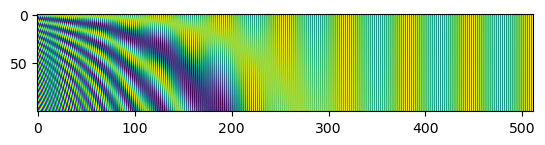

In [6]:
import math

"""
Standard positional encoding layer adopted from "Attention Is All You Need"
"""
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[: x.size(0)]
        return self.dropout(x)
    
enc = PositionalEncoding(d_model=512, max_len=100)
plt.imshow(enc.pe.squeeze())

### Attention mechanism

- introduce attention
$$
\text{attention}(\textbf{Q}, \textbf{K}, \textbf{V}) = \text{softmax}\left(\dfrac{\textbf{Q}\textbf{K}^T}{\sqrt{d}}\right) \textbf{V}
$$
- show importance of attention
- masked attention

In [7]:
"""
Standard Scaled Dot product attention mechanism
"""
class DotProductAttention(nn.Module):

    def __init__(self, dropout_rate: float = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout_rate)
        self.attention_weight = torch.Tensor(0)

    def forward(self, query: torch.Tensor, keys: torch.Tensor, vals: torch.Tensor, mask: torch.Tensor = None):
        # query/keys: (batch_size, n_heads, seq_len, n_hidden/n_heads)
        # vals:       (batch_size, n_heads, seq_len, n_hidden/n_heads)
        d = query.shape[-1]

        # (batch_size, n_heads, seq_len, seq_len)
        presoftmax = query @ keys.transpose(-2, -1) / d ** 0.5
        if mask is not None:
            presoftmax = presoftmax.masked_fill(mask == 0, float('-inf'))

        self.attention_weight = F.softmax(presoftmax, dim=-1)
        self.attention_weight = self.dropout(self.attention_weight)
        # out: (batch_size, n_heads, seq_len, n_hidden/n_heads)
        return self.attention_weight @ vals, self.attention_weight

### Multi-head attention

In [8]:
"""
Multi-head attention mechanism.
"""
class MultiHeadAttention(nn.Module):

    def __init__(
        self, attention: nn.Module, n_heads: int, n_hidden: int, n_out: int, bias=False
    ):
        super().__init__()
        self.n_heads = n_heads
        self.n_hidden = n_hidden
        self.W_q = nn.LazyLinear(n_hidden, bias=bias)
        self.W_k = nn.LazyLinear(n_hidden, bias=bias)
        self.W_v = nn.LazyLinear(n_hidden, bias=bias)
        self.W_o = nn.LazyLinear(n_out)
        self.attention = attention
        self.attn_weights = torch.Tensor(0)

    def transpose_QKV(self, X: torch.Tensor):
        X = X.reshape(*X.shape[:2], self.n_heads, -1)
        X = X.permute(0, 2, 1, 3)  # (batch_size, n_heads, seq_len, n_hidden/n_heads)
        return X

    def forward(
        self,
        queries: torch.Tensor,
        keys: torch.Tensor,
        values: torch.Tensor,
        mask: torch.Tensor = None,
    ):
        
        K = self.transpose_QKV(self.W_k(keys))
        V = self.transpose_QKV(self.W_v(values))
        Q = self.transpose_QKV(self.W_q(queries))
        # Q, K, V: (batch_size, n_heads, seq_len, n_hidden/n_heads)

        out, self.attn_weights = self.attention(Q, K, V, mask)
        out = out.reshape(
            out.shape[0], out.shape[2], -1
        )  # (batch_size, seq_len, n_hidden*n_heads)

        return self.W_o(out)
    
mha = MultiHeadAttention(DotProductAttention(), 4, 64, 20)

x = torch.randn(32, 8, 20)
mha(x, x, x).shape

c:\Users\janba\anaconda3\envs\workspace_jan\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([32, 8, 20])

### Residual addition and layer normalisation

Y = Norm(X + f(X))

In [9]:
class AddNorm(nn.Module):
    def __init__(self, norm_shape, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(norm_shape)
    
    def forward(self, X: torch.Tensor, Y: torch.Tensor):
        return self.layer_norm(self.dropout(Y) + X)

add_norm = AddNorm(4)
x = torch.randn(32, 8, 4)
add_norm(x, x).shape

torch.Size([32, 8, 4])

### Position-wise feedforward network

In [10]:
class PositionWiseFFN(nn.Module):
    def __init__(self, ffn_n_hidden, ffn_n_outputs):
        super().__init__()
        self.dense1 = nn.LazyLinear(ffn_n_hidden)
        self.relu = nn.ReLU()
        self.dense2 = nn.LazyLinear(ffn_n_outputs)
        
    def forward(self, X: torch.Tensor):
        return self.dense2(self.relu(self.dense1(X)))

ffn = PositionWiseFFN(4, 8)
x = torch.randn(32, 3, 4)
ffn(x).shape

torch.Size([32, 3, 8])

### Single Transformer Block

combine layer norm, multi-head attention, position-wise feedforward

In [11]:
class TransformerBlock(nn.Module):
    def __init__(
        self,
        n_heads=8,
        n_hidden=64,
        n_out=512,
        ffn_n_hidden=2048,
        _attention=DotProductAttention(),
        dropout=0.1,
    ):
        """
        :param n_heads: number of attention heads
        :param n_hidden: dimensionality of each attention head
        :param n_out: dimensionality of output (after multi-head attention and after point-wise feedforward network)
        :param ffn_n_hidden: hidden dimension of feedforward network
        :param _attention: self attention module (default: DotProductAttention)
        :param dropout: dropout rate
        :param norm_first: whether to apply layer normalization before attention layer or after
        """
        super().__init__()
        self.mha = MultiHeadAttention(_attention, n_heads, n_hidden, n_out)
        self.add_norm1 = AddNorm(n_out, dropout)
        self.ffn = PositionWiseFFN(ffn_n_hidden, n_out)
        self.add_norm2 = AddNorm(n_out, dropout)
        
    def forward(self, X: torch.Tensor, mask: torch.Tensor = None):
        sublayer1 = self.add_norm1(X, self.mha(X, X, X, mask))
        sublayer2 = self.add_norm2(sublayer1, self.ffn(sublayer1))

        return sublayer2

tb = TransformerBlock()
x = torch.randn(32, 8, 512)
tb(x).shape

torch.Size([32, 8, 512])

### Stack of Transformer Blocks

In [12]:
import copy

"""
Autoregressive decoder-only Transformer model. 
Uses naive linear layer for embedding.
"""
class DecoderOnlyTransformer(nn.Module):

    def __init__(
        self,
        vocab_size: int,
        emb_size: int=512,
        n_heads: int=8,
        n_hidden: int=64,
        ffn_n_hidden: int=2048,
        num_layers: int=3,
        _attention: nn.Module=DotProductAttention()
    ):
        """
        :param vocab_size: number of possible input tokens
        :param emb_size: embedding size of d_in (d_model)
        :param n_heads: number of heads in multi-head attention
        :param n_hidden: number of units in Query, Key, Value projection in multi-head attention
        :param ffn_n_hidden: number of hidden units in point-wise FFN
        :param num_layers: number of attention decoder layers
        :param _attention: attention module (default: DotProductAttention)
        """
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_size)
        self.pos_enc = PositionalEncoding(emb_size)

        decoder_block = TransformerBlock(
            n_heads=n_heads,
            n_hidden=n_hidden,
            n_out=emb_size,
            ffn_n_hidden=ffn_n_hidden,
            _attention=_attention
        )
        self.transformer_blocks = nn.ModuleList(
            [copy.deepcopy(decoder_block) for _ in range(num_layers)]
        )
        self.output_layer = nn.LazyLinear(vocab_size)

    def forward(self, X: torch.Tensor, mask: torch.Tensor = None):
        # shape X:  (batch_size, seq_len, 1)
        
        # embedding: (batch_size, seq_len, 1) -> (batch_size, seq_len, emb_size)
        # positional embedding: (seq_len) -> (seq_len, emb_size)
        X = self.pos_enc(self.emb(X))

        # through decoder blocks with same mask shape (seq_len, seq_len)
        for block in self.transformer_blocks:
            X = block(X, mask=mask)

        # output shape: (batch_size, seq_len, vocab_size)
        return self.output_layer(X)

## Test on Shakespeare dataset

In [27]:
# Training constants
EPOCHS = 20
BATCH_SIZE = 512
LEARNING_RATE = 0.001
LEARNING_RATE_GAMMA = 0.9

SEQ_LEN = 32

# Model constants
EMB_SIZE = 64
N_HEADS = 4
N_HIDDEN = EMB_SIZE // N_HEADS
FFN_N_HIDDEN = 4 * EMB_SIZE
NUM_LAYERS = 4

# check for possible GPU usage
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [28]:
dataset = VocabDataset("../datasets/shakespeare.txt", seq_len=SEQ_LEN)

train_indices = list(range(0, int(len(dataset) * 0.8)))
val_indices = list(range(int(len(dataset) * 0.8), int(len(dataset) * 0.9)))
test_indices = list(range(int(len(dataset) * 0.9), len(dataset)))

train_set = torch.utils.data.Subset(dataset, train_indices)
val_set = torch.utils.data.Subset(dataset, val_indices)
test_set = torch.utils.data.Subset(dataset, test_indices)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

len(train_loader), len(val_loader), len(test_loader)

(1743, 218, 218)

In [29]:
model = DecoderOnlyTransformer(
    vocab_size=dataset.vocab_size,
    emb_size=EMB_SIZE,
    n_heads=N_HEADS,
    n_hidden=N_HIDDEN,
    ffn_n_hidden=FFN_N_HIDDEN,
    num_layers=NUM_LAYERS
).to(DEVICE)

optim = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=LEARNING_RATE_GAMMA)

train_history = []
val_history = []

mask = torch.tril(torch.ones((SEQ_LEN, SEQ_LEN)), diagonal=0).to(DEVICE)

for epoch in range(EPOCHS):
    
    batch_losses = []
    for i, (batch_x, batch_y) in enumerate(train_loader):
        
        batch_x, batch_y = batch_x.to(DEVICE), batch_y.to(DEVICE)

        y_pred = model(batch_x, mask)
        y_pred = y_pred.transpose(1, 2)

        loss = F.cross_entropy(y_pred, batch_y)
        batch_losses.append(loss.item())
        
        optim.zero_grad()
        loss.backward()
        optim.step()

    scheduler.step()

    train_history.append(torch.mean(torch.tensor(batch_losses)))

    batch_losses = []
    with torch.no_grad():
        for i, (batch_x, batch_y) in enumerate(val_loader):
            batch_x, batch_y = batch_x.to(DEVICE), batch_y.to(DEVICE)

            y_pred = model(batch_x, mask)
            y_pred = y_pred.transpose(1, 2)
            
            loss = F.cross_entropy(y_pred, batch_y)
            batch_losses.append(loss.item())

    val_history.append(torch.mean(torch.tensor(batch_losses)))
    
    print(f"epoch {epoch}, train_loss {train_history[-1]}, val_loss {val_history[-1]}")


c:\Users\janba\anaconda3\envs\workspace_jan\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


epoch 0, train_loss 1.706408977508545, val_loss 1.1587496995925903
epoch 1, train_loss 0.7618384957313538, val_loss 0.5244892835617065
epoch 2, train_loss 0.44842588901519775, val_loss 0.41576847434043884
epoch 3, train_loss 0.35413122177124023, val_loss 0.3207229971885681
epoch 4, train_loss 0.27267923951148987, val_loss 0.26050451397895813
epoch 5, train_loss 0.23340347409248352, val_loss 0.23008586466312408
epoch 6, train_loss 0.21037890017032623, val_loss 0.19758880138397217
epoch 7, train_loss 0.17440922558307648, val_loss 0.17120862007141113
epoch 8, train_loss 0.1566377878189087, val_loss 0.15531180799007416
epoch 9, train_loss 0.14547251164913177, val_loss 0.14699578285217285
epoch 10, train_loss 0.1382502317428589, val_loss 0.14017353951931
epoch 11, train_loss 0.13273419439792633, val_loss 0.13548968732357025
epoch 12, train_loss 0.12856410443782806, val_loss 0.13094714283943176
epoch 13, train_loss 0.1249811053276062, val_loss 0.12912523746490479
epoch 14, train_loss 0.12229

In [70]:
max_new_tokens = 200

# idx = torch.zeros((1, 1), dtype=torch.long, device=DEVICE)
idx, _ = test_set[15]
idx = idx.unsqueeze(0).to(DEVICE)

# idx is (B, T) array of indices in the current context
for _ in range(max_new_tokens):
    # crop idx to the last block_size tokens
    idx_cond = idx[:, -SEQ_LEN:]
    # get the predictions
    logits = model(idx_cond, mask)
    # focus only on the last time step
    logits = logits[:, -1, :] # becomes (B, C)
    # apply softmax to get probabilities
    probs = F.softmax(logits, dim=-1) # (B, C)
    # sample from the distribution
    idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
    # append sampled index to the running sequence
    idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)

print(''.join(dataset.decoder(idx.squeeze().tolist())))

who comes here?

GREMIO:
Good modme'sese kithsy
Jor,
th than melen tle, liced, tot this sy
I Byou it the hot now; wicestony, froot
thise areringray that I your aif goti
A he yeesown, deto cele
flok
Gors of eestay; out day frotand th
